Throughout this notebook, we've covered various aspects of univariate and multivariate time series forecasting using Python and pandas.

1. **Data Preprocessing**:
   - We started by loading and preprocessing time series data using pandas. This involved converting date columns to datetime format, grouping data, and calculating summary statistics like mean, median, and quantiles.
   - We also performed data splitting into train and test sets to facilitate model training and evaluation.

2. **Univariate Forecasting**:
   - In univariate forecasting, we focused on forecasting a single time series variable.
   - We explored models such as SARIMA and Prophet for univariate time series forecasting.
   - For SARIMA and Prophet models, we defined the models, fit them to the univariate data, and made forecasts for future time periods.
   - We evaluated the performance of univariate models using metrics like Mean Squared Error (MSE) and Mean Absolute Error (MAE).

3. **Multivariate Forecasting**:
   - In multivariate forecasting, we considered multiple time series variables simultaneously.
   - We implemented a VAR (Vector Autoregression) model for multivariate time series forecasting.
   - The VAR model allowed us to capture the interdependencies between multiple variables in the time series data.
   - We split the data into train and test sets, fit the VAR model, and forecasted future values for all variables in the dataset.
   - Evaluation of multivariate models also involved metrics like MSE and MAE, but applied to multiple variables.

4. **Visualization**:
   - We visualized the forecasted values using matplotlib, which provides a clear understanding of how our models are performing and how the forecasted values compare to the actual data.
   - Visualization is essential for both univariate and multivariate forecasting to analyze model performance and make informed decisions.

5. **Refactoring**:
   - We refactored our code to make it cleaner, more readable, and compliant with PEP 8 guidelines.
   - Refactoring involved renaming variables, adding comments, and organizing the code in a structured manner to improve maintainability.

#### import libs

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import datetime
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.api import VAR
from dateutil.relativedelta import relativedelta

In [25]:
# Read the data from CSV files into DataFrames
df_ma_price = pd.read_csv(r'C:\Users\yeswa\OneDrive\Desktop\time_series\data\House Property Sales Tim\ma_lga_12345.csv')
df_raw_sales = pd.read_csv(r'C:\Users\yeswa\OneDrive\Desktop\time_series\data\House Property Sales Tim\raw_sales.csv')

# Display the first few rows of the DataFrame df_ma_price
df_ma_price.head()


,datesold,postcode,price,propertyType,bedrooms
0,07-02-2007 00:00,2607,525000,house,4
1,27-02-2007 00:00,2906,290000,house,3
2,07-03-2007 00:00,2905,328000,house,3
3,09-03-2007 00:00,2905,380000,house,4
4,21-03-2007 00:00,2906,310000,house,3


In [26]:
# Get the shape (number of rows and columns) of the DataFrame df_ma_price
num_rows, num_cols = df_ma_price.shape

# Print the shape
print("Number of rows:", num_rows)
print("Number of columns:", num_cols)


Number of rows: 29580
Number of columns: 5


In [27]:
# Display the first few rows of the DataFrame df_raw_sales
df_raw_sales.head()

,datesold,postcode,price,propertyType,bedrooms
0,2007-02-07 00:00:00,2607,525000,house,4
1,2007-02-27 00:00:00,2906,290000,house,3
2,2007-03-07 00:00:00,2905,328000,house,3
3,2007-03-09 00:00:00,2905,380000,house,4
4,2007-03-21 00:00:00,2906,310000,house,3


In [28]:
# Get the shape of the DataFrame df_raw_sales
shape_raw_sales = df_raw_sales.shape

# Print the shape
print("Shape of df_raw_sales:", shape_raw_sales)

Shape of df_raw_sales: (29580, 5)


In [29]:
# Display the first two rows of the DataFrame df_raw_sales
df_raw_sales.head(2)

,datesold,postcode,price,propertyType,bedrooms
0,2007-02-07 00:00:00,2607,525000,house,4
1,2007-02-27 00:00:00,2906,290000,house,3


#### per day

In [30]:
# Convert 'datesold' column to datetime format if it's not already in datetime format
df_raw_sales['datesold'] = pd.to_datetime(df_raw_sales['datesold'])

# Group the DataFrame by 'datesold' and count the number of rows in each group
result = df_raw_sales.groupby('datesold').size().reset_index(name='sold_qty')

# Display the first few rows of the result DataFrame
result.head()

,datesold,sold_qty
0,2007-02-07,1
1,2007-02-27,1
2,2007-03-07,1
3,2007-03-09,1
4,2007-03-21,1


#### check for missing values by year

In [31]:
# Convert 'datesold' column to datetime format if it's not already
df_raw_sales['datesold'] = pd.to_datetime(df_raw_sales['datesold'])

# Create a date range from the minimum to maximum dates in the 'datesold' column
date_range = pd.date_range(start=df_raw_sales['datesold'].min(), end=df_raw_sales['datesold'].max())

# Convert the date range to a DataFrame with 'datesold' as the column name
date_range_df = pd.DataFrame(date_range, columns=['datesold'])

# Merge the date range DataFrame with the original DataFrame to find missing dates
missing_dates = pd.merge(date_range_df, df_raw_sales, on='datesold', how='left')

# Filter out the existing dates by checking for missing 'postcode' values
missing_dates = missing_dates[missing_dates['postcode'].isnull()]

# Extract year, month, and day from the missing dates
missing_dates['year'] = missing_dates['datesold'].dt.year
missing_dates['month'] = missing_dates['datesold'].dt.month
missing_dates['day'] = missing_dates['datesold'].dt.day

# Group by year and count missing dates to get the number of missing days for each year
missing_days_count = missing_dates.groupby(missing_dates['year']).size().reset_index(name='missing_days')

# Display the first few rows of the missing days count DataFrame
missing_days_count.head()


,year,missing_days
0,2007,232
1,2008,159
2,2009,75
3,2010,64
4,2011,66


When faced with incomplete sales data spanning specific periods, such as 2007 and 2008, interpolation methods can be employed to estimate missing values based on the available data points. Linear interpolation stands out as a simple yet effective approach for this purpose. By assuming a linear trend between adjacent data points, missing values are filled in with estimates derived from the surrounding known data. This method can be particularly useful for approximating sales figures on days where no data is available, thus providing a more complete and continuous representation of the sales trend within the specified timeframe. Through linear interpolation, gaps in the sales data can be seamlessly bridged, enabling a more comprehensive analysis and understanding of the underlying sales patterns over the specified period.

In [32]:
# Convert 'datesold' column to datetime
result['datesold'] = pd.to_datetime(result['datesold'])

# Set 'datesold' column as index
result = result.set_index('datesold')

# Create a date range from the minimum to maximum dates in the 'datesold' column
date_range = pd.date_range(start=result.index.min(), end=result.index.max())

# Reindex DataFrame to include all dates in the range and reset index to bring 'datesold' column back
result = result.reindex(date_range).rename_axis('datesold').reset_index()

# Perform linear interpolation to fill missing values
result['sold_qty_interpolated'] = result['sold_qty'].interpolate(method='linear')

# Drop the 'sold_qty' column
result = result.drop(columns=['sold_qty'])

# Rename the 'sold_qty_interpolated' column to 'sold_qty'
result = result.rename(columns={'sold_qty_interpolated': 'sold_qty'})

# Display the first few rows of the result DataFrame
result.head()

,datesold,sold_qty
0,2007-02-07,1.0
1,2007-02-08,1.0
2,2007-02-09,1.0
3,2007-02-10,1.0
4,2007-02-11,1.0


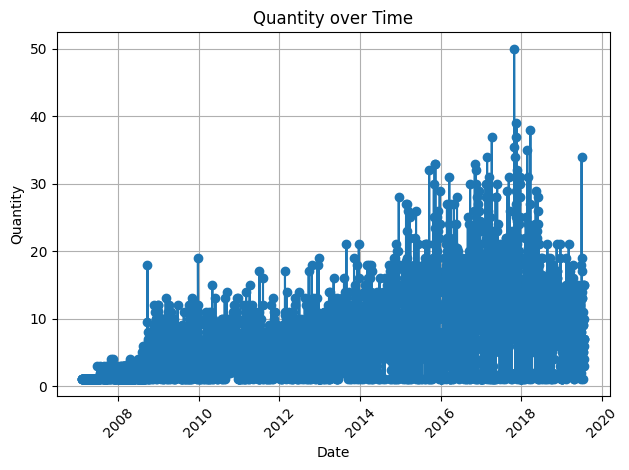

In [33]:
# Convert 'datesold' column to datetime format if it's not already
result['datesold'] = pd.to_datetime(result['datesold'])

# Plotting
plt.plot(result['datesold'], result['sold_qty'], marker='o', linestyle='-')
plt.title('Quantity over Time')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)
plt.tight_layout()

# Show plot
plt.show()

#### aggregate to week

In [34]:
# Group by week (or 7 days) and aggregate the quantity
result_week = result.groupby(pd.Grouper(key='datesold', freq='W-MON'))['sold_qty'].sum().reset_index()

# Rename the columns to match the desired output
result_week.columns = ['Week_Start', 'sold_qty']

# Display the shape of the DataFrame
print('Shape of DataFrame:', result_week.shape)

# Display the last few rows of the DataFrame
result_week.tail()

Shape of DataFrame: (651, 2)


,Week_Start,sold_qty
646,2019-07-01,70.0
647,2019-07-08,89.0
648,2019-07-15,39.0
649,2019-07-22,64.0
650,2019-07-29,43.0


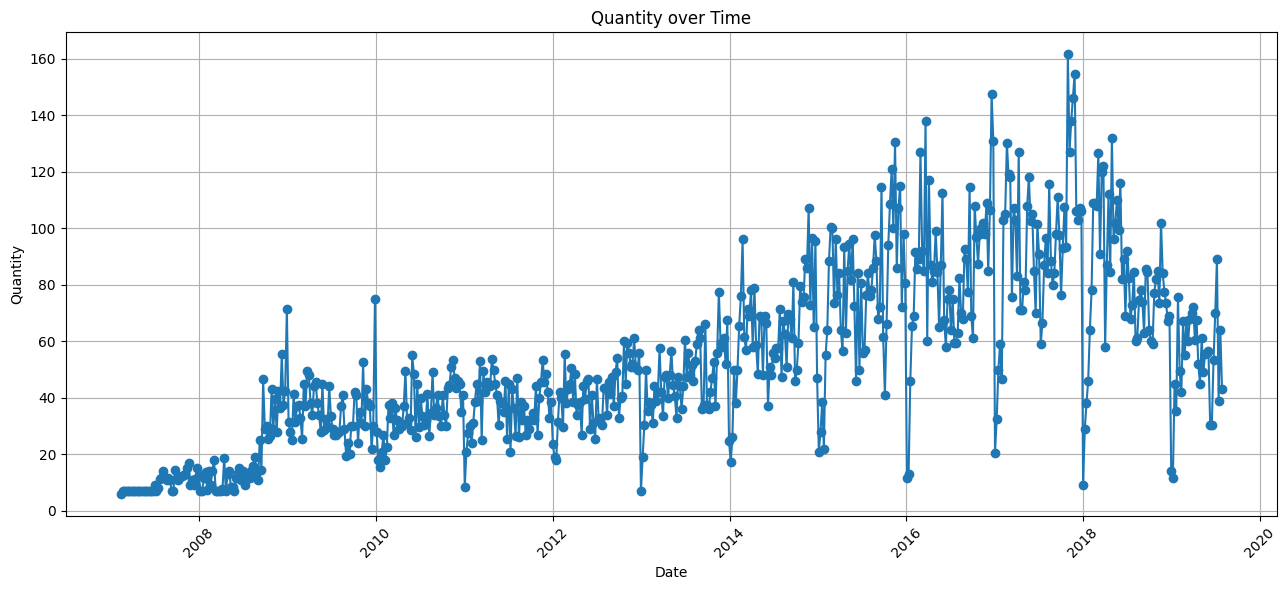

In [35]:
# Create a copy of result_week DataFrame
df = result_week.copy()

# Convert 'Week_Start' column to datetime format if it's not already
df['Week_Start'] = pd.to_datetime(df['Week_Start'])

# Define plot size
plt.figure(figsize=(13, 6))

# Plotting
plt.plot(df['Week_Start'], df['sold_qty'], marker='o', linestyle='-')
plt.title('Quantity over Time')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)
plt.tight_layout()

# Show plot
plt.show()

### Uni Variant models

##### day

In [36]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from prophet import Prophet
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import LSTM, Dense

def forecast_sales(data, column_name, forecast_horizon=7, window_size=4543):
    """
    Forecast sales using multiple time series models and calculate error metrics.

    Parameters:
    data (pd.DataFrame): DataFrame containing the sales data.
    column_name (str): Column name of the sales data.
    forecast_horizon (int): Number of weeks to forecast. Default is 7.
    window_size (int): Size of the sliding window for backtesting in weeks. Default is 30.

    Returns:
    dict: Dictionary containing error metrics and forecast values.
    """
    # Normalize the sales data column
    scaler = MinMaxScaler()
    data[column_name] = scaler.fit_transform(data[[column_name]])

    def sliding_window_forecast(data, window_size=4533, forecast_horizon=7):
        """
        Generate sliding windows for backtesting.

        Parameters:
        data (pd.DataFrame): DataFrame containing the sales data.
        window_size (int): Size of the sliding window.
        forecast_horizon (int): Number of months to forecast.

        Yields:
        tuple: Tuple containing the training and test sets for each window.
        """
        train_size = len(data) - forecast_horizon
        cumulative_length = 0  # Initialize cumulative length counter

        for i in range(train_size - window_size + 1):
            train = data.iloc[i:i + window_size]
            test = data.iloc[i + window_size:i + window_size + forecast_horizon]
            cumulative_length += len(train)
            print(f"Length of training data in iteration {i+1}: {len(train)}, Cumulative length: {cumulative_length}")
            yield train, test

    def calculate_errors(actual, predicted):
        """
        Calculate MAE and MSE error metrics.

        Parameters:
        actual (np.array): Array of actual values.
        predicted (np.array): Array of predicted values.

        Returns:
        tuple: Tuple containing MAE and MSE.
        """
        mae = mean_absolute_error(actual, predicted)
        mse = mean_squared_error(actual, predicted)
        return mae, mse

    def forecast_arima(train, test):
        """
        Forecast using ARIMA model.

        Parameters:
        train (pd.DataFrame): Training set.
        test (pd.DataFrame): Test set.

        Returns:
        np.array: Forecasted values.
        """
        model = ARIMA(train[column_name], order=(5, 1, 0))
        model_fit = model.fit()
        forecast = model_fit.forecast(steps=len(test))
        return forecast

    def forecast_sarima(train, test):
        """
        Forecast using SARIMAX model.

        Parameters:
        train (pd.DataFrame): Training set.
        test (pd.DataFrame): Test set.

        Returns:
        np.array: Forecasted values.
        """
        try:
            order = (1, 1, 1)  # Simpler (p, d, q)
            seasonal_order = (1, 1, 1, 7)  # Keeping seasonal order same
            model = SARIMAX(train[column_name], order=order, seasonal_order=seasonal_order)
            model_fit = model.fit(disp=False)
            forecast = model_fit.forecast(steps=len(test))
            return forecast
        except np.linalg.LinAlgError:
            print("SARIMAX model fitting failed due to LinAlgError")
            return np.zeros(len(test))

    def forecast_ets(train, test):
        """
        Forecast using ETS model.

        Parameters:
        train (pd.DataFrame): Training set.
        test (pd.DataFrame): Test set.

        Returns:
        np.array: Forecasted values.
        """
        seasonal_periods = min(len(train), 7)  # Adjusted seasonal periods
        model = ExponentialSmoothing(train[column_name], seasonal='add', seasonal_periods=seasonal_periods)
        model_fit = model.fit()
        forecast = model_fit.forecast(steps=len(test))
        return forecast

    def forecast_prophet(train, test):
        """
        Forecast using Prophet model.

        Parameters:
        train (pd.DataFrame): Training set.
        test (pd.DataFrame): Test set.

        Returns:
        np.array: Forecasted values.
        """
        train_prophet = train.rename(columns={'date': 'ds', column_name: 'y'})
        model = Prophet()
        model.fit(train_prophet)
        future = model.make_future_dataframe(periods=len(test), freq='W')
        forecast = model.predict(future)
        return forecast['yhat'][-len(test):].values

    def forecast_lstm(train, test):
        """
        Forecast using LSTM model.

        Parameters:
        train (pd.DataFrame): Training set.
        test (pd.DataFrame): Test set.

        Returns:
        np.array: Forecasted values.
        """
        series = train[column_name].values
        generator = TimeseriesGenerator(series, series, length=10, batch_size=1)
        model = Sequential()
        model.add(LSTM(50, activation='relu', input_shape=(10, 1)))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')
        model.fit(generator, epochs=20, verbose=0)
        test_series = train[column_name].values[-10:]
        forecast = []
        for _ in range(len(test)):
            x_input = test_series[-10:].reshape((1, 10, 1))
            yhat = model.predict(x_input, verbose=0)
            forecast.append(yhat[0][0])
            test_series = np.append(test_series, yhat)
        return np.array(forecast)

    # Initialize dictionaries to store results
    forecast_dict = {}
    error_dict = {}

    # Run backtesting with sliding windows
    for train, test in sliding_window_forecast(data, window_size, forecast_horizon):
        actual = test[column_name].values

        # ARIMA model
        arima_forecast = forecast_arima(train, test)
        mae, mse = calculate_errors(actual, arima_forecast)
        error_dict.setdefault('ARIMA', []).append({'MAE': mae, 'MSE': mse})
        forecast_dict.setdefault('ARIMA', []).append(arima_forecast)

        # SARIMAX model
        sarima_forecast = forecast_sarima(train, test)
        mae, mse = calculate_errors(actual, sarima_forecast)
        error_dict.setdefault('SARIMA', []).append({'MAE': mae, 'MSE': mse})
        forecast_dict.setdefault('SARIMA', []).append(sarima_forecast)

        # ETS model
        ets_forecast = forecast_ets(train, test)
        mae, mse = calculate_errors(actual, ets_forecast)
        error_dict.setdefault('ETS', []).append({'MAE': mae, 'MSE': mse})
        forecast_dict.setdefault('ETS', []).append(ets_forecast)

        # Prophet model
        prophet_forecast = forecast_prophet(train, test)
        mae, mse = calculate_errors(actual, prophet_forecast)
        error_dict.setdefault('Prophet', []).append({'MAE': mae, 'MSE': mse})
        forecast_dict.setdefault('Prophet', []).append(prophet_forecast)

        # LSTM model
        lstm_forecast = forecast_lstm(train, test)
        mae, mse = calculate_errors(actual, lstm_forecast)
        error_dict.setdefault('LSTM', []).append({'MAE': mae, 'MSE': mse})
        forecast_dict.setdefault('LSTM', []).append(lstm_forecast)

    # Calculate average error metrics for backtesting
    average_error_dict = {model: {'MAE': np.mean([x['MAE'] for x in errors]),
                                  'MSE': np.mean([x['MSE'] for x in errors])}
                          for model, errors in error_dict.items()}

    # Convert error metrics to DataFrame
    error_df = pd.DataFrame(average_error_dict).T
    error_df.index.name = 'Model'
    error_df.columns = ['MAE', 'MSE']

    # Initialize dictionary for final forecasts
    final_forecast_dict = {}

    def final_forecast(model_func, data, forecast_horizon):
        """
        Generate final forecast using the specified model function.

        Parameters:
        model_func (function): Forecast function for the model.
        data (pd.DataFrame): DataFrame containing the sales data.
        forecast_horizon (int): Number of weeks to forecast.

        Returns:
        tuple: Tuple containing forecast dates and values.
        """
        dates = pd.date_range(start=data['date'].iloc[-1] + pd.Timedelta(days=7), periods=forecast_horizon, freq='W')
        forecast = model_func(data, pd.DataFrame(index=dates))
        return dates, forecast

    # ARIMA final forecast
    final_forecast_dict['ARIMA'] = forecast_arima(data, pd.DataFrame(index=pd.date_range(start=data['date'].iloc[-1] + pd.Timedelta(days=7), periods=forecast_horizon, freq='W')))

    # SARIMAX final forecast
    final_forecast_dict['SARIMA'] = forecast_sarima(data, pd.DataFrame(index=pd.date_range(start=data['date'].iloc[-1] + pd.Timedelta(days=7), periods=forecast_horizon, freq='W')))

    # ETS final forecast
    final_forecast_dict['ETS'] = forecast_ets(data, pd.DataFrame(index=pd.date_range(start=data['date'].iloc[-1] + pd.Timedelta(days=7), periods=forecast_horizon, freq='W')))

    # Prophet final forecast
    prophet_dates, prophet_forecast = final_forecast(forecast_prophet, data, forecast_horizon)
    final_forecast_dict['Prophet'] = {'dates': prophet_dates, 'forecast': prophet_forecast}

    # LSTM final forecast
    lstm_dates, lstm_forecast = final_forecast(forecast_lstm, data, forecast_horizon)
    final_forecast_dict['LSTM'] = {'dates': lstm_dates, 'forecast': lstm_forecast}

    # Combine forecasts into a DataFrame
    forecast_df = pd.DataFrame(index=prophet_dates)

    # Add forecast values for each model and inverse transform them
    for model in final_forecast_dict:
        forecast_values = final_forecast_dict[model]
        if model in ['Prophet', 'LSTM']:
            forecast_df[model] = scaler.inverse_transform(forecast_values['forecast'].reshape(-1, 1)).flatten().astype(int)
        else:
            forecast_df[model] = scaler.inverse_transform(forecast_values.values.reshape(-1, 1)).flatten().astype(int)

    # Rename the index to 'Date'
    forecast_df.index.name = 'Date'

    # Output object
    result = {
        'error_metrics': error_df,
        'forecasts': forecast_df
    }

    return result


In [37]:
result.tail()

,datesold,sold_qty
4549,2019-07-23,15.0
4550,2019-07-24,4.0
4551,2019-07-25,15.0
4552,2019-07-26,6.0
4553,2019-07-27,3.0


In [38]:
result.shape

(4554, 2)

In [39]:
# Load the data
# data = result_week.copy() 
data = result.copy() 

# Rename the column
data.rename(columns={'datesold': 'date'}, inplace=True)

# Call the function
daily_forecast_result = forecast_sales(data, 'sold_qty')

# Print the results
print("Backtesting Error Metrics:")
print(daily_forecast_result['error_metrics'])

print("Final Forecasts for the next 7 days:")
print(daily_forecast_result['forecasts'])

Length of training data in iteration 1: 4543, Cumulative length: 4543


11:51:19 - cmdstanpy - INFO - Chain [1] start processing
11:51:19 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Length of training data in iteration 2: 4543, Cumulative length: 9086


11:56:31 - cmdstanpy - INFO - Chain [1] start processing
11:56:32 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Length of training data in iteration 3: 4543, Cumulative length: 13629


c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
12:01:13 - cmdstanpy - INFO - Chain [1] start processing
12:01:13 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these argum

Length of training data in iteration 4: 4543, Cumulative length: 18172


12:06:01 - cmdstanpy - INFO - Chain [1] start processing
12:06:02 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Length of training data in iteration 5: 4543, Cumulative length: 22715


12:10:59 - cmdstanpy - INFO - Chain [1] start processing
12:10:59 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
12:15:49 - cmdstanpy - INFO - Chain [1] start processing
12:15:49 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-p

Backtesting Error Metrics:
              MAE       MSE
Model                      
ARIMA    0.074317  0.007829
SARIMA   0.065998  0.007062
ETS      0.070105  0.007499
Prophet  0.066669  0.008829
LSTM     0.060173  0.007077
Final Forecasts for the next 7 days:
            ARIMA  SARIMA  ETS  Prophet  LSTM
Date                                         
2019-08-04      7       5    6        6     6
2019-08-11      7       8    9        6     7
2019-08-18      7       9    9        6     8
2019-08-25      8       9    9        6     8
2019-09-01      6       8    7        6     8
2019-09-08      6       8    8        6     7
2019-09-15      7       6    6        6     7


##### forecast visualization - daily

In [40]:
result.head()

,datesold,sold_qty
0,2007-02-07,1.0
1,2007-02-08,1.0
2,2007-02-09,1.0
3,2007-02-10,1.0
4,2007-02-11,1.0


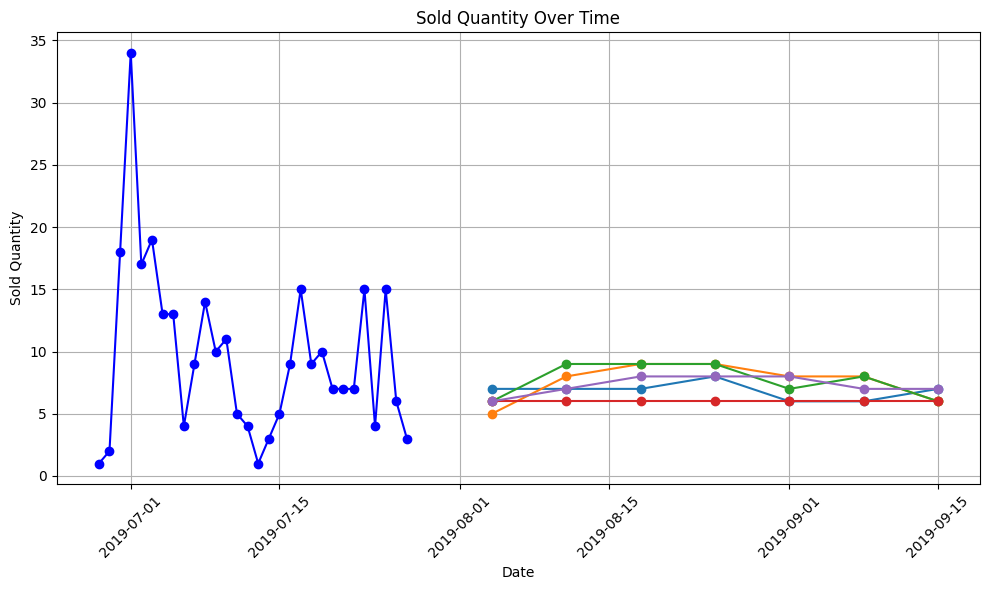

In [41]:

data = result.copy()

# Plotting
plt.figure(figsize=(10, 6))  # Adjust size if needed

plt.plot(data['datesold'][-30:], data['sold_qty'][-30:], marker='o', linestyle='-', color='b')

# Plot each model's forecasted values
for col in daily_forecast_result['forecasts'].columns:
    plt.plot(daily_forecast_result['forecasts'].index, daily_forecast_result['forecasts'][col], marker='o', linestyle='-', label=col)

# Formatting
plt.title('Sold Quantity Over Time')
plt.xlabel('Date')
plt.ylabel('Sold Quantity')
plt.grid(True)
plt.xticks(rotation=45)

# Show plot
plt.tight_layout()
plt.show()

##### week

In [42]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from prophet import Prophet
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import LSTM, Dense

def forecast_week_sales(data, column_name, forecast_horizon=7, window_size=640):
    """
    Forecast sales using multiple time series models and calculate error metrics.

    Parameters:
    data (pd.DataFrame): DataFrame containing the sales data.
    column_name (str): Column name of the sales data.
    forecast_horizon (int): Number of weeks to forecast. Default is 7.
    window_size (int): Size of the sliding window for backtesting in weeks. Default is 30.

    Returns:
    dict: Dictionary containing error metrics and forecast values.
    """
    # Convert the date column to datetime if it's not already
    if not pd.api.types.is_datetime64_any_dtype(data['date']):
        data['date'] = pd.to_datetime(data['date'])

    # Aggregate the data into weekly sums
    data.set_index('date', inplace=True)
    data = data.resample('W').sum().reset_index()

    # Normalize the sales data column
    scaler = MinMaxScaler()
    data[column_name] = scaler.fit_transform(data[[column_name]])

    def sliding_window_forecast(data, window_size=640, forecast_horizon=7):
        """
        Generate sliding windows for backtesting.

        Parameters:
        data (pd.DataFrame): DataFrame containing the sales data.
        window_size (int): Size of the sliding window.
        forecast_horizon (int): Number of months to forecast.

        Yields:
        tuple: Tuple containing the training and test sets for each window.
        """
        train_size = len(data) - forecast_horizon
        cumulative_length = 0  # Initialize cumulative length counter

        for i in range(train_size - window_size + 1):
            train = data.iloc[i:i + window_size]
            test = data.iloc[i + window_size:i + window_size + forecast_horizon]
            cumulative_length += len(train)
            print(f"Length of training data in iteration {i+1}: {len(train)}, Cumulative length: {cumulative_length}")
            yield train, test

    def calculate_errors(actual, predicted):
        """
        Calculate MAE and MSE error metrics.

        Parameters:
        actual (np.array): Array of actual values.
        predicted (np.array): Array of predicted values.

        Returns:
        tuple: Tuple containing MAE and MSE.
        """
        mae = mean_absolute_error(actual, predicted)
        mse = mean_squared_error(actual, predicted)
        return mae, mse

    def forecast_arima(train, test):
        """
        Forecast using ARIMA model.

        Parameters:
        train (pd.DataFrame): Training set.
        test (pd.DataFrame): Test set.

        Returns:
        np.array: Forecasted values.
        """
        model = ARIMA(train[column_name], order=(5, 1, 0))
        model_fit = model.fit()
        forecast = model_fit.forecast(steps=len(test))
        return forecast

    def forecast_sarima(train, test):
        """
        Forecast using SARIMAX model.

        Parameters:
        train (pd.DataFrame): Training set.
        test (pd.DataFrame): Test set.

        Returns:
        np.array: Forecasted values.
        """
        try:
            order = (1, 1, 1)  # Simpler (p, d, q)
            seasonal_order = (1, 1, 1, 52)  # Keeping seasonal order same
            model = SARIMAX(train[column_name], order=order, seasonal_order=seasonal_order)
            model_fit = model.fit(disp=False)
            forecast = model_fit.forecast(steps=len(test))
            return forecast
        except np.linalg.LinAlgError:
            print("SARIMAX model fitting failed due to LinAlgError")
            return np.zeros(len(test))

    def forecast_ets(train, test):
        """
        Forecast using ETS model.

        Parameters:
        train (pd.DataFrame): Training set.
        test (pd.DataFrame): Test set.

        Returns:
        np.array: Forecasted values.
        """
        seasonal_periods = 52  # Adjusted seasonal periods
        if len(train) >= seasonal_periods:  # if len(train) >= 2 * seasonal_periods:
            model = ExponentialSmoothing(train[column_name], seasonal='add', seasonal_periods=seasonal_periods)
            model_fit = model.fit()
            forecast = model_fit.forecast(steps=len(test))
            return forecast
        else:
            print("Not enough data for ETS model")
            return np.zeros(len(test))

    def forecast_prophet(train, test):
        """
        Forecast using Prophet model.

        Parameters:
        train (pd.DataFrame): Training set.
        test (pd.DataFrame): Test set.

        Returns:
        np.array: Forecasted values.
        """
        train_prophet = train.rename(columns={'date': 'ds', column_name: 'y'})
        model = Prophet()
        model.fit(train_prophet)
        future = model.make_future_dataframe(periods=len(test), freq='W')
        forecast = model.predict(future)
        return forecast['yhat'][-len(test):].values

    def forecast_lstm(train, test):
        """
        Forecast using LSTM model.

        Parameters:
        train (pd.DataFrame): Training set.
        test (pd.DataFrame): Test set.

        Returns:
        np.array: Forecasted values.
        """
        series = train[column_name].values
        if len(series) < 10:
            print("Not enough data for LSTM model")
            return np.zeros(len(test))
        generator = TimeseriesGenerator(series, series, length=10, batch_size=1)
        model = Sequential()
        model.add(LSTM(50, activation='relu', input_shape=(10, 1)))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')
        model.fit(generator, epochs=20, verbose=0)
        test_series = train[column_name].values[-10:]
        forecast = []
        for _ in range(len(test)):
            x_input = test_series[-10:].reshape((1, 10, 1))
            yhat = model.predict(x_input, verbose=0)
            forecast.append(yhat[0][0])
            test_series = np.append(test_series, yhat)
        return np.array(forecast)

    # Initialize dictionaries to store results
    forecast_dict = {}
    error_dict = {}

    # Run backtesting with sliding windows
    for train, test in sliding_window_forecast(data, window_size, forecast_horizon):
        actual = test[column_name].values

        # ARIMA model
        arima_forecast = forecast_arima(train, test)
        mae, mse = calculate_errors(actual, arima_forecast)
        error_dict.setdefault('ARIMA', []).append({'MAE': mae, 'MSE': mse})
        forecast_dict.setdefault('ARIMA', []).append(arima_forecast)

        # SARIMAX model
        sarima_forecast = forecast_sarima(train, test)
        mae, mse = calculate_errors(actual, sarima_forecast)
        error_dict.setdefault('SARIMA', []).append({'MAE': mae, 'MSE': mse})
        forecast_dict.setdefault('SARIMA', []).append(sarima_forecast)

        # ETS model
        ets_forecast = forecast_ets(train, test)
        mae, mse = calculate_errors(actual, ets_forecast)
        error_dict.setdefault('ETS', []).append({'MAE': mae, 'MSE': mse})
        forecast_dict.setdefault('ETS', []).append(ets_forecast)

        # Prophet model
        prophet_forecast = forecast_prophet(train, test)
        mae, mse = calculate_errors(actual, prophet_forecast)
        error_dict.setdefault('Prophet', []).append({'MAE': mae, 'MSE': mse})
        forecast_dict.setdefault('Prophet', []).append(prophet_forecast)

        # LSTM model
        lstm_forecast = forecast_lstm(train, test)
        mae, mse = calculate_errors(actual, lstm_forecast)
        error_dict.setdefault('LSTM', []).append({'MAE': mae, 'MSE': mse})
        forecast_dict.setdefault('LSTM', []).append(lstm_forecast)

    # Calculate average error metrics for backtesting
    average_error_dict = {model: {'MAE': np.mean([x['MAE'] for x in errors]),
                                  'MSE': np.mean([x['MSE'] for x in errors])}
                          for model, errors in error_dict.items()}

    # Convert error metrics to DataFrame
    error_df = pd.DataFrame(average_error_dict).T
    error_df.index.name = 'Model'
    error_df.columns = ['MAE', 'MSE']

    # Initialize dictionary for final forecasts
    final_forecast_dict = {}

    def final_forecast(model_func, data, forecast_horizon):
        """
        Generate final forecast using the specified model function.

        Parameters:
        model_func (function): Forecast function for the model.
        data (pd.DataFrame): DataFrame containing the sales data.
        forecast_horizon (int): Number of weeks to forecast.

        Returns:
        tuple: Tuple containing forecast dates and values.
        """
        dates = pd.date_range(start=data['date'].iloc[-1] + pd.Timedelta(days=7), periods=forecast_horizon, freq='W')
        forecast = model_func(data, pd.DataFrame(index=dates))
        return dates, forecast

    # ARIMA final forecast
    final_forecast_dict['ARIMA'] = forecast_arima(data, pd.DataFrame(index=pd.date_range(start=data['date'].iloc[-1] + pd.Timedelta(days=7), periods=forecast_horizon, freq='W')))

    # SARIMAX final forecast
    final_forecast_dict['SARIMA'] = forecast_sarima(data, pd.DataFrame(index=pd.date_range(start=data['date'].iloc[-1] + pd.Timedelta(days=7), periods=forecast_horizon, freq='W')))

    # ETS final forecast
    final_forecast_dict['ETS'] = forecast_ets(data, pd.DataFrame(index=pd.date_range(start=data['date'].iloc[-1] + pd.Timedelta(days=7), periods=forecast_horizon, freq='W')))

    # Prophet final forecast
    prophet_dates, prophet_forecast = final_forecast(forecast_prophet, data, forecast_horizon)
    final_forecast_dict['Prophet'] = {'dates': prophet_dates, 'forecast': prophet_forecast}

    # LSTM final forecast
    lstm_dates, lstm_forecast = final_forecast(forecast_lstm, data, forecast_horizon)
    final_forecast_dict['LSTM'] = {'dates': lstm_dates, 'forecast': lstm_forecast}

    # Combine forecasts into a DataFrame
    forecast_df = pd.DataFrame(index=prophet_dates)

    # Add forecast values for each model and inverse transform them
    for model in final_forecast_dict:
        forecast_values = final_forecast_dict[model]
        if model in ['Prophet', 'LSTM']:
            forecast_df[model] = scaler.inverse_transform(forecast_values['forecast'].reshape(-1, 1)).flatten().astype(int)
        else:
            forecast_df[model] = scaler.inverse_transform(forecast_values.values.reshape(-1, 1)).flatten().astype(int)

    # Rename the index to 'Date'
    forecast_df.index.name = 'Date'

    # Output object
    result = {
        'error_metrics': error_df,
        'forecasts': forecast_df
    }

    return result


In [43]:
# Load the data
data = result.copy() 

# Rename the column
data.rename(columns={'datesold': 'date'}, inplace=True)

# Call the function
week_sales_forecast_result = forecast_week_sales(data, 'sold_qty')

# Print the results
print("Backtesting Error Metrics:")
print(week_sales_forecast_result['error_metrics'])

print("Final Forecasts for the next 7 weeks:")
print(week_sales_forecast_result['forecasts'])

Length of training data in iteration 1: 640, Cumulative length: 640


12:21:30 - cmdstanpy - INFO - Chain [1] start processing
12:21:30 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Length of training data in iteration 2: 640, Cumulative length: 1280


12:23:27 - cmdstanpy - INFO - Chain [1] start processing
12:23:28 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Length of training data in iteration 3: 640, Cumulative length: 1920


12:25:09 - cmdstanpy - INFO - Chain [1] start processing
12:25:09 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Length of training data in iteration 4: 640, Cumulative length: 2560


12:26:53 - cmdstanpy - INFO - Chain [1] start processing
12:26:53 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Length of training data in iteration 5: 640, Cumulative length: 3200


12:28:39 - cmdstanpy - INFO - Chain [1] start processing
12:28:39 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


##### forecast visualization - week

    datesold  sold_qty
0 2007-02-11       5.0
1 2007-02-18       7.0
2 2007-02-25       7.0
3 2007-03-04       7.0
4 2007-03-11       7.0


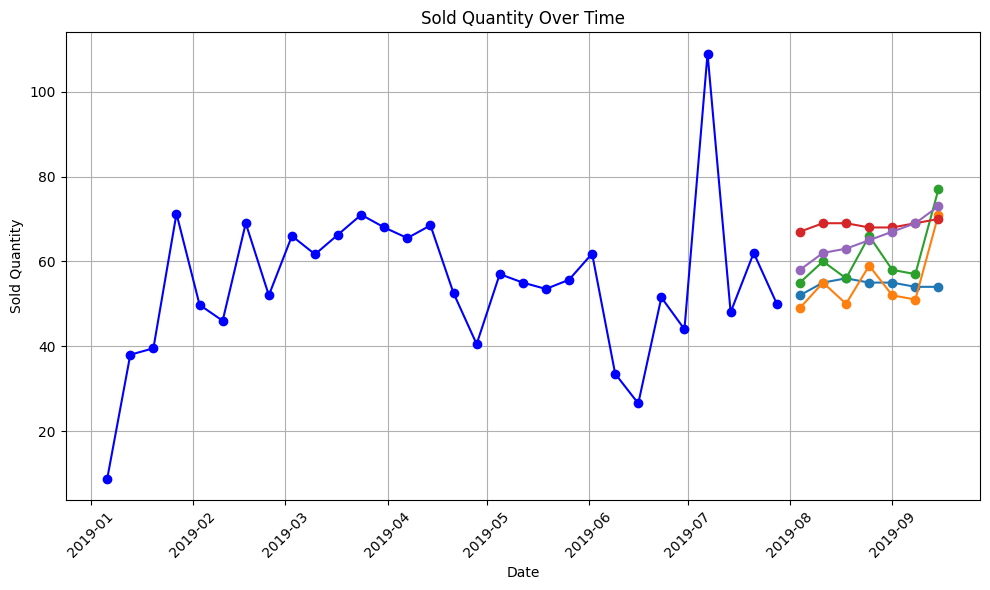

In [ ]:
data = result.copy()
# Plotting
plt.figure(figsize=(10, 6))  # Adjust size if needed

# Set 'date' as the index
data.set_index('datesold', inplace=True)

# Resample by week and aggregate using sum
df_weekly = data.resample('W').sum()

df_weekly.reset_index(inplace=True)

print(df_weekly.head())

plt.plot(df_weekly['datesold'][-30:], df_weekly['sold_qty'][-30:], marker='o', linestyle='-', color='b')
# plt.plot(df_weekly['date'], df_weekly['sold_qty'], marker='o', linestyle='-', color='b')

# Plot each model's forecasted values
for col in week_sales_forecast_result['forecasts'].columns:
    plt.plot(week_sales_forecast_result['forecasts'].index, week_sales_forecast_result['forecasts'][col], marker='o', linestyle='-', label=col)

# Formatting
plt.title('Sold Quantity Over Time')
plt.xlabel('Date')
plt.ylabel('Sold Quantity')
plt.grid(True)
plt.xticks(rotation=45)

# Show plot
plt.tight_layout()
plt.show()

##### month

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from prophet import Prophet
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
# from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import LSTM, Dense

def forecast_monthly_sales(data, column_name, forecast_horizon=6, window_size=130):
    """
    Forecast sales using multiple time series models and calculate error metrics.

    Parameters:
    data (pd.DataFrame): DataFrame containing the sales data.
    column_name (str): Column name of the sales data.
    forecast_horizon (int): Number of months to forecast. Default is 6.
    window_size (int): Size of the sliding window for backtesting in months. Default is 6.

    Returns:
    dict: Dictionary containing error metrics and forecast values.
    """
    # Convert the date column to datetime if it's not already
    if not pd.api.types.is_datetime64_any_dtype(data['date']):
        data['date'] = pd.to_datetime(data['date'])

    # Aggregate the data into monthly sums
    data.set_index('date', inplace=True)
    data = data.resample('MS').sum().reset_index()

    # Normalize the sales data column
    scaler = MinMaxScaler()
    data[column_name] = scaler.fit_transform(data[[column_name]])

    def sliding_window_forecast(data, window_size=130, forecast_horizon=6):
        """
        Generate sliding windows for backtesting.

        Parameters:
        data (pd.DataFrame): DataFrame containing the sales data.
        window_size (int): Size of the sliding window.
        forecast_horizon (int): Number of months to forecast.

        Yields:
        tuple: Tuple containing the training and test sets for each window.
        """
        train_size = len(data) - forecast_horizon
        cumulative_length = 0  # Initialize cumulative length counter

        for i in range(train_size - window_size + 1):
            train = data.iloc[i:i + window_size]
            test = data.iloc[i + window_size:i + window_size + forecast_horizon]
            cumulative_length += len(train)
            print(f"Length of training data in iteration {i+1}: {len(train)}, Cumulative length: {cumulative_length}")
            yield train, test

    def calculate_errors(actual, predicted):
        """
        Calculate MAE and MSE error metrics.

        Parameters:
        actual (np.array): Array of actual values.
        predicted (np.array): Array of predicted values.

        Returns:
        tuple: Tuple containing MAE and MSE.
        """
        mae = mean_absolute_error(actual, predicted)
        mse = mean_squared_error(actual, predicted)
        return mae, mse

    def forecast_arima(train, test):
        """
        Forecast using ARIMA model.

        Parameters:
        train (pd.DataFrame): Training set.
        test (pd.DataFrame): Test set.

        Returns:
        np.array: Forecasted values.
        """
        model = ARIMA(train[column_name], order=(5, 1, 0))
        model_fit = model.fit()
        forecast = model_fit.forecast(steps=len(test))
        return forecast

    def forecast_sarima(train, test):
        """
        Forecast using SARIMAX model.

        Parameters:
        train (pd.DataFrame): Training set.
        test (pd.DataFrame): Test set.

        Returns:
        np.array: Forecasted values.
        """
        try:
            order = (1, 1, 1)  # Simpler (p, d, q)
            seasonal_order = (1, 1, 1, 12)  # Monthly seasonality
            model = SARIMAX(train[column_name], order=order, seasonal_order=seasonal_order)
            model_fit = model.fit(disp=False)
            forecast = model_fit.forecast(steps=len(test))
            return forecast
        except np.linalg.LinAlgError:
            print("SARIMAX model fitting failed due to LinAlgError")
            return np.zeros(len(test))

    def forecast_ets(train, test):
        """
        Forecast using ETS model.

        Parameters:
        train (pd.DataFrame): Training set.
        test (pd.DataFrame): Test set.

        Returns:
        np.array: Forecasted values.
        """
        seasonal_periods = 12  # Monthly seasonality
        if len(train) >= 2 * seasonal_periods:
            model = ExponentialSmoothing(train[column_name], seasonal='add', seasonal_periods=seasonal_periods)
            model_fit = model.fit()
            forecast = model_fit.forecast(steps=len(test))
            return forecast
        else:
            print("Not enough data for ETS model")
            return np.zeros(len(test))

    def forecast_prophet(train, test):
        """
        Forecast using Prophet model.

        Parameters:
        train (pd.DataFrame): Training set.
        test (pd.DataFrame): Test set.

        Returns:
        np.array: Forecasted values.
        """
        train_prophet = train.rename(columns={'date': 'ds', column_name: 'y'})
        model = Prophet()
        model.fit(train_prophet)
        future = model.make_future_dataframe(periods=len(test), freq='MS')
        forecast = model.predict(future)
        return forecast['yhat'][-len(test):].values

    def forecast_lstm(train, test):
        """
        Forecast using LSTM model.

        Parameters:
        train (pd.DataFrame): Training set.
        test (pd.DataFrame): Test set.

        Returns:
        np.array: Forecasted values.
        """
        series = train[column_name].values
        if len(series) < 10:
            print("Not enough data for LSTM model")
            return np.zeros(len(test))
        generator = TimeseriesGenerator(series, series, length=10, batch_size=1)
        model = Sequential()
        model.add(LSTM(50, activation='relu', input_shape=(10, 1)))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')
        model.fit(generator, epochs=20, verbose=0)
        test_series = train[column_name].values[-10:]
        forecast = []
        for _ in range(len(test)):
            x_input = test_series[-10:].reshape((1, 10, 1))
            yhat = model.predict(x_input, verbose=0)
            forecast.append(yhat[0][0])
            test_series = np.append(test_series, yhat)
        return np.array(forecast)

    # Initialize dictionaries to store results
    forecast_dict = {}
    error_dict = {}

    # Run backtesting with sliding windows
    for train, test in sliding_window_forecast(data, window_size, forecast_horizon):
        actual = test[column_name].values

        # ARIMA model
        arima_forecast = forecast_arima(train, test)
        mae, mse = calculate_errors(actual, arima_forecast)
        error_dict.setdefault('ARIMA', []).append({'MAE': mae, 'MSE': mse})
        forecast_dict.setdefault('ARIMA', []).append(arima_forecast)

        # SARIMAX model
        sarima_forecast = forecast_sarima(train, test)
        mae, mse = calculate_errors(actual, sarima_forecast)
        error_dict.setdefault('SARIMA', []).append({'MAE': mae, 'MSE': mse})
        forecast_dict.setdefault('SARIMA', []).append(sarima_forecast)

        # ETS model
        ets_forecast = forecast_ets(train, test)
        mae, mse = calculate_errors(actual, ets_forecast)
        error_dict.setdefault('ETS', []).append({'MAE': mae, 'MSE': mse})
        forecast_dict.setdefault('ETS', []).append(ets_forecast)

        # Prophet model
        prophet_forecast = forecast_prophet(train, test)
        mae, mse = calculate_errors(actual, prophet_forecast)
        error_dict.setdefault('Prophet', []).append({'MAE': mae, 'MSE': mse})
        forecast_dict.setdefault('Prophet', []).append(prophet_forecast)

        # LSTM model
        lstm_forecast = forecast_lstm(train, test)
        mae, mse = calculate_errors(actual, lstm_forecast)
        error_dict.setdefault('LSTM', []).append({'MAE': mae, 'MSE': mse})
        forecast_dict.setdefault('LSTM', []).append(lstm_forecast)

    # Calculate average error metrics for backtesting
    average_error_dict = {model: {'MAE': np.mean([x['MAE'] for x in errors]),
                                  'MSE': np.mean([x['MSE'] for x in errors])}
                          for model, errors in error_dict.items()}

    # Convert error metrics to DataFrame
    error_df = pd.DataFrame(average_error_dict).T
    error_df.index.name = 'Model'
    error_df.columns = ['MAE', 'MSE']

    # Initialize dictionary for final forecasts
    final_forecast_dict = {}

    def final_forecast(model_func, data, forecast_horizon):
        """
        Generate final forecast using the specified model function.

        Parameters:
        model_func (function): Forecast function for the model.
        data (pd.DataFrame): DataFrame containing the sales data.
        forecast_horizon (int): Number of months to forecast.

        Returns:
        tuple: Tuple containing forecast dates and values.
        """
        dates = pd.date_range(start=data['date'].iloc[-1] + pd.DateOffset(months=1), periods=forecast_horizon, freq='MS')
        forecast = model_func(data, pd.DataFrame(index=dates))
        return dates, forecast

    # ARIMA final forecast
    final_forecast_dict['ARIMA'] = forecast_arima(data, pd.DataFrame(index=pd.date_range(start=data['date'].iloc[-1] + pd.DateOffset(months=1), periods=forecast_horizon, freq='MS')))

    # SARIMAX final forecast
    final_forecast_dict['SARIMA'] = forecast_sarima(data, pd.DataFrame(index=pd.date_range(start=data['date'].iloc[-1] + pd.DateOffset(months=1), periods=forecast_horizon, freq='MS')))

    # ETS final forecast
    final_forecast_dict['ETS'] = forecast_ets(data, pd.DataFrame(index=pd.date_range(start=data['date'].iloc[-1] + pd.DateOffset(months=1), periods=forecast_horizon, freq='MS')))

    # Prophet final forecast
    prophet_dates, prophet_forecast = final_forecast(forecast_prophet, data, forecast_horizon)
    final_forecast_dict['Prophet'] = {'dates': prophet_dates, 'forecast': prophet_forecast}

    # LSTM final forecast
    lstm_dates, lstm_forecast = final_forecast(forecast_lstm, data, forecast_horizon)
    final_forecast_dict['LSTM'] = {'dates': lstm_dates, 'forecast': lstm_forecast}

    # Combine forecasts into a DataFrame
    forecast_df = pd.DataFrame(index=prophet_dates)

    # Add forecast values for each model and inverse transform them
    for model in final_forecast_dict:
        forecast_values = final_forecast_dict[model]
        if model in ['Prophet', 'LSTM']:
            forecast_df[model] = scaler.inverse_transform(forecast_values['forecast'].reshape(-1, 1)).flatten().astype(int)
        else:
            if isinstance(forecast_values, np.ndarray):
                forecast_df[model] = scaler.inverse_transform(forecast_values.reshape(-1, 1)).flatten().astype(int)
            else:
                forecast_df[model] = scaler.inverse_transform(forecast_values.values.reshape(-1, 1)).flatten().astype(int)

    # Rename the index to 'Date'
    forecast_df.index.name = 'Date'

    # Output object
    result = {
        'error_metrics': error_df,
        'forecasts': forecast_df
    }

    return result


In [ ]:
# Load the data
data = result.copy() 

# Rename the column
data.rename(columns={'datesold': 'date'}, inplace=True)

# Call the function
monthly_sales_result = forecast_monthly_sales(data, 'sold_qty')

# Print the results
print("Backtesting Error Metrics:")
print(monthly_sales_result['error_metrics'])

print("Final Forecasts for the next 6 months :")
print(monthly_sales_result['forecasts'])

Length of training data in iteration 1: 130, Cumulative length: 130


23:11:49 - cmdstanpy - INFO - Chain [1] start processing
23:11:49 - cmdstanpy - INFO - Chain [1] done processing
/home/prasanna/Desktop/time_series_forecast/.venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/prasanna/Desktop/time_series_forecast/.venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Length of training data in iteration 2: 130, Cumulative length: 260


23:12:02 - cmdstanpy - INFO - Chain [1] start processing
23:12:02 - cmdstanpy - INFO - Chain [1] done processing
/home/prasanna/Desktop/time_series_forecast/.venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/prasanna/Desktop/time_series_forecast/.venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Length of training data in iteration 3: 130, Cumulative length: 390


23:12:15 - cmdstanpy - INFO - Chain [1] start processing
23:12:15 - cmdstanpy - INFO - Chain [1] done processing
/home/prasanna/Desktop/time_series_forecast/.venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/prasanna/Desktop/time_series_forecast/.venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Length of training data in iteration 4: 130, Cumulative length: 520


23:12:28 - cmdstanpy - INFO - Chain [1] start processing
23:12:28 - cmdstanpy - INFO - Chain [1] done processing
/home/prasanna/Desktop/time_series_forecast/.venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/prasanna/Desktop/time_series_forecast/.venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Length of training data in iteration 5: 130, Cumulative length: 650


23:12:41 - cmdstanpy - INFO - Chain [1] start processing
23:12:41 - cmdstanpy - INFO - Chain [1] done processing
/home/prasanna/Desktop/time_series_forecast/.venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/prasanna/Desktop/time_series_forecast/.venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Length of training data in iteration 6: 130, Cumulative length: 780


23:12:54 - cmdstanpy - INFO - Chain [1] start processing
23:12:54 - cmdstanpy - INFO - Chain [1] done processing
/home/prasanna/Desktop/time_series_forecast/.venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/prasanna/Desktop/time_series_forecast/.venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Length of training data in iteration 7: 130, Cumulative length: 910


23:13:07 - cmdstanpy - INFO - Chain [1] start processing
23:13:07 - cmdstanpy - INFO - Chain [1] done processing
/home/prasanna/Desktop/time_series_forecast/.venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/prasanna/Desktop/time_series_forecast/.venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Length of training data in iteration 8: 130, Cumulative length: 1040


23:13:20 - cmdstanpy - INFO - Chain [1] start processing
23:13:20 - cmdstanpy - INFO - Chain [1] done processing
/home/prasanna/Desktop/time_series_forecast/.venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/prasanna/Desktop/time_series_forecast/.venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Length of training data in iteration 9: 130, Cumulative length: 1170


23:13:33 - cmdstanpy - INFO - Chain [1] start processing
23:13:33 - cmdstanpy - INFO - Chain [1] done processing
/home/prasanna/Desktop/time_series_forecast/.venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/prasanna/Desktop/time_series_forecast/.venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Length of training data in iteration 10: 130, Cumulative length: 1300


23:13:46 - cmdstanpy - INFO - Chain [1] start processing
23:13:46 - cmdstanpy - INFO - Chain [1] done processing
/home/prasanna/Desktop/time_series_forecast/.venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/prasanna/Desktop/time_series_forecast/.venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Length of training data in iteration 11: 130, Cumulative length: 1430


23:13:59 - cmdstanpy - INFO - Chain [1] start processing
23:13:59 - cmdstanpy - INFO - Chain [1] done processing
/home/prasanna/Desktop/time_series_forecast/.venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/prasanna/Desktop/time_series_forecast/.venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Length of training data in iteration 12: 130, Cumulative length: 1560


23:14:12 - cmdstanpy - INFO - Chain [1] start processing
23:14:12 - cmdstanpy - INFO - Chain [1] done processing
/home/prasanna/Desktop/time_series_forecast/.venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/prasanna/Desktop/time_series_forecast/.venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Length of training data in iteration 13: 130, Cumulative length: 1690


23:14:25 - cmdstanpy - INFO - Chain [1] start processing
23:14:25 - cmdstanpy - INFO - Chain [1] done processing
/home/prasanna/Desktop/time_series_forecast/.venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/prasanna/Desktop/time_series_forecast/.venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Length of training data in iteration 14: 130, Cumulative length: 1820


23:14:38 - cmdstanpy - INFO - Chain [1] start processing
23:14:38 - cmdstanpy - INFO - Chain [1] done processing
/home/prasanna/Desktop/time_series_forecast/.venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/prasanna/Desktop/time_series_forecast/.venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Length of training data in iteration 15: 130, Cumulative length: 1950


23:14:52 - cmdstanpy - INFO - Chain [1] start processing
23:14:52 - cmdstanpy - INFO - Chain [1] done processing
/home/prasanna/Desktop/time_series_forecast/.venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/prasanna/Desktop/time_series_forecast/.venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
23:15:07 - cmdstanpy - INFO - Chain [1] start processing
23:15:07 - cmdstanpy - INFO - Chain [1] done processing
/home/prasanna/Desktop/time_series_for

Backtesting Error Metrics:
              MAE       MSE
Model                      
ARIMA    0.129778  0.025332
SARIMA   0.144631  0.032898
ETS      0.131243  0.025689
Prophet  0.222521  0.066025
LSTM     0.168263  0.039355
Final Forecasts for the next 6 months :
            ARIMA  SARIMA  ETS  Prophet  LSTM
Date                                         
2019-08-01    270     222  234      365   254
2019-09-01    240     225  248      354   255
2019-10-01    250     244  273      375   256
2019-11-01    239     316  344      421   258
2019-12-01    225     205  242      374   261
2020-01-01    252      68  109      270   264


##### forecast visulaization - month

/tmp/ipykernel_22554/1001434890.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = data.resample('M').sum()


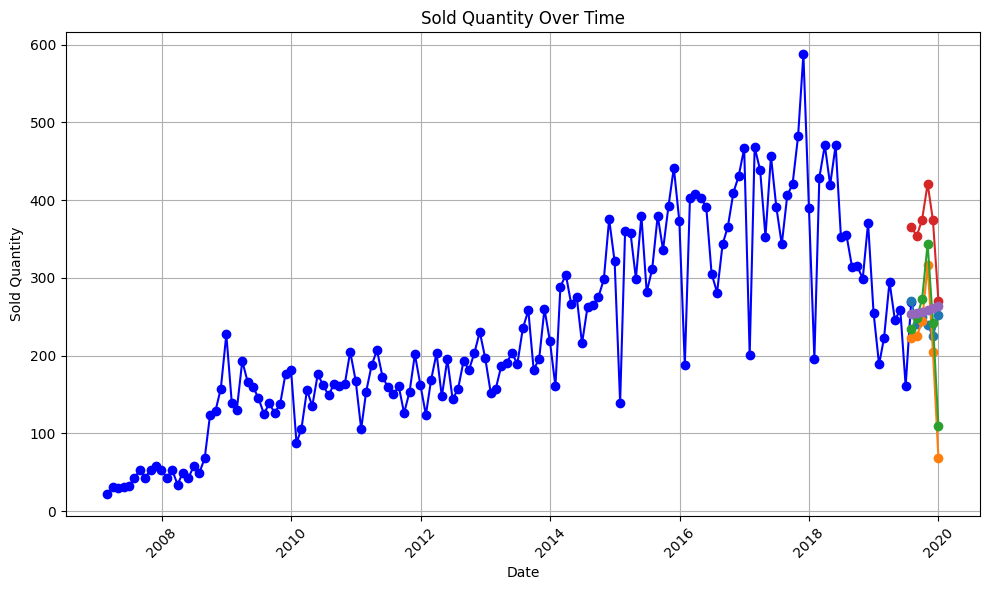

In [ ]:
data = result.copy()
# Plotting
plt.figure(figsize=(10, 6))  # Adjust size if needed

# Set 'date' as the index
data.set_index('datesold', inplace=True)

# Resample by month and aggregate using sum
df_monthly = data.resample('M').sum()

df_monthly.reset_index(inplace=True)

plt.plot(df_monthly['datesold'], df_monthly['sold_qty'], marker='o', linestyle='-', color='b')
# plt.plot(df_weekly['date'], df_weekly['sold_qty'], marker='o', linestyle='-', color='b')

# Plot each model's forecasted values
for col in monthly_sales_result['forecasts'].columns:
    plt.plot(monthly_sales_result['forecasts'].index, monthly_sales_result['forecasts'][col], marker='o', linestyle='-', label=col)

# Formatting
plt.title('Sold Quantity Over Time')
plt.xlabel('Date')
plt.ylabel('Sold Quantity')
plt.grid(True)
plt.xticks(rotation=45)

# Show plot
plt.tight_layout()
plt.show()

### multi variant time series

In [ ]:
df_ma_price.head(2)

,saledate,MA,type,bedrooms
0,30/09/2007,441854,house,2
1,31/12/2007,441854,house,2


In [ ]:
# Convert 'saledate' column to datetime format with day first
df_ma_price['saledate'] = pd.to_datetime(df_ma_price['saledate'], dayfirst=True)

# Group the DataFrame by 'type' and 'bedrooms'
grouped_df_ma_price = df_ma_price.groupby(['type', 'bedrooms'])

# Calculate the count, mean, median, 25th, 50th, 75th quantiles, minimum, and maximum for each group
summary_stats = grouped_df_ma_price['MA'].agg(['count', 'mean', 'median', lambda x: x.quantile(0.25), lambda x: x.quantile(0.5), lambda x: x.quantile(0.75), 'min', 'max'])

# Rename the columns for clarity
summary_stats.columns = ['Count', 'Mean', 'Median', '25th Quantile', '50th Quantile', '75th Quantile', 'Minimum', 'Maximum']

# Print the summary statistics
print(summary_stats)


                Count           Mean    Median  25th Quantile  50th Quantile  \
type  bedrooms                                                                 
house 2            49  471453.979592  469920.0      454270.00       469920.0   
      3            51  518357.745098  507090.0      470511.50       507090.0   
      4            51  669803.803922  636687.0      604071.00       636687.0   
      5            49  854328.102041  807826.0      775199.00       807826.0   
unit  1            48  332724.416667  332876.0      326076.00       332876.0   
      2            50  415339.300000  425836.5      409583.25       425836.5   
      3            49  569479.571429  581428.0      535063.00       581428.0   

                75th Quantile  Minimum  Maximum  
type  bedrooms                                   
house 2              489104.0   440123   510712  
      3              568424.5   416031   631875  
      4              741294.5   548969   837295  
      5              952327.0

In [ ]:
# Filter the DataFrame to include only rows where the 'type' column is 'house'
df_ma_house_price = df_ma_price[df_ma_price['type'] == 'house']

# Display the first few rows of the filtered DataFrame
df_ma_house_price.head()

,saledate,MA,type,bedrooms
0,2007-09-30,441854,house,2
1,2007-12-31,441854,house,2
2,2008-03-31,441854,house,2
3,2008-06-30,441854,house,2
4,2008-09-30,451583,house,2


In [ ]:
# Pivot the DataFrame so that each unique value in the 'bedrooms' column becomes a separate column, with 'saledate' as the index
df_ma_house_price = df_ma_house_price.pivot(index='saledate', columns='bedrooms', values='MA')

# Interpolate missing values using linear interpolation method, filling gaps in the data
# 'limit_direction' parameter ensures interpolation is performed both forward and backward
df_ma_house_price = df_ma_house_price.interpolate(method='linear', limit_direction='both')

# Display the last few rows of the pivoted and interpolated DataFrame
df_ma_house_price.tail()


bedrooms,2,3,4,5
saledate,,,,
2018-09-30,504318.0,624602.0,830727.0,1007114.0
2018-12-31,506001.0,626608.0,820924.0,1002323.0
2019-03-31,496133.0,628423.0,811121.0,998136.0
2019-06-30,500158.0,630814.0,803925.0,995363.0
2019-09-30,510712.0,631875.0,791446.0,970268.0


<Figure size 1500x1000 with 0 Axes>

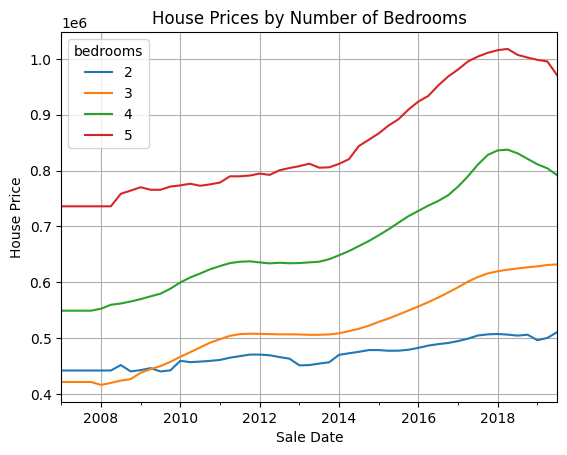

In [ ]:
# Ensure plots are displayed inline in the notebook
%matplotlib inline

# Plot the DataFrame with house prices for different bedrooms
plt.figure(figsize=(15, 10))  # Set the figure size
df_ma_house_price.plot()  # Plot the data
plt.title('House Prices by Number of Bedrooms')  # Set the title
plt.xlabel('Sale Date')  # Set the x-axis label
plt.ylabel('House Price')  # Set the y-axis label
plt.grid(True)  # Enable gridlines
plt.show()  # Show the plot


<Axes: xlabel='saledate'>

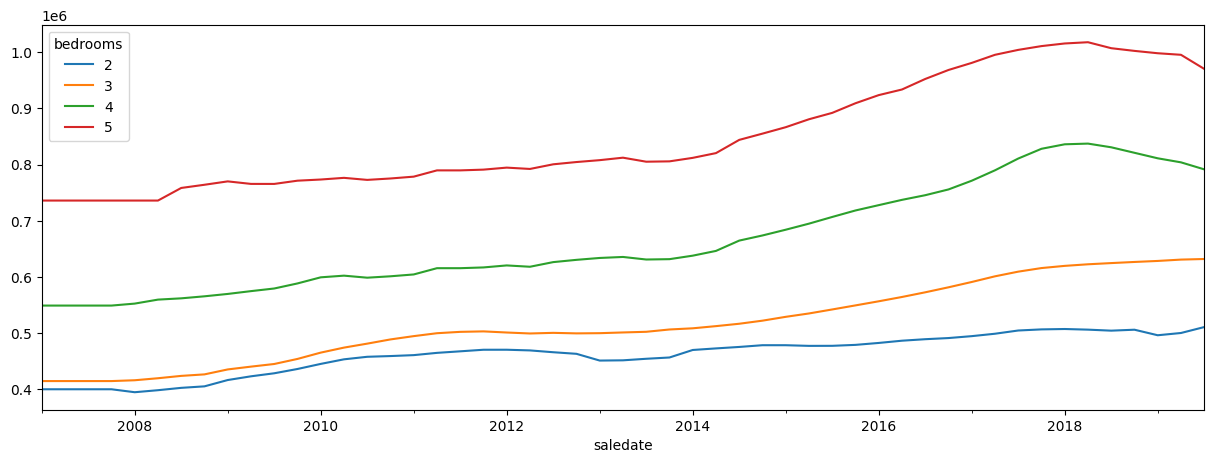

In [ ]:
def separate_series(df):
    columns = list(df)
    for col in columns:
        if col == columns[-1]:
            break
        # Calculate average difference between 2 and 3 bedrooms for the recent 1/3 of the dataframe
        diff_mean = (df[col + 1][:-int(len(df) / 3)] - df[col][:-int(len(df) / 3)]).mean()
        # Where 2 bedrooms price is higher than that of 3 bedrooms, replace it with 3 bedrooms price minus the difference
        df.loc[df[col] > df[col + 1] - diff_mean, col] = df[col + 1] - diff_mean
    return df

# Separate overlapping series
df_ma_house_price = separate_series(df_ma_house_price)

# Plot the separated series
df_ma_house_price.plot(figsize=(15, 5))


In [ ]:
df_ma_house_price.tail()

bedrooms,2,3,4,5
saledate,,,,
2018-09-30,504318.0,624602.0,830727.0,1007114.0
2018-12-31,506001.0,626608.0,820924.0,1002323.0
2019-03-31,496133.0,628423.0,811121.0,998136.0
2019-06-30,500158.0,630814.0,803925.0,995363.0
2019-09-30,510712.0,631875.0,791446.0,970268.0


In [ ]:
# Split the data into train and test sets
train = df_ma_house_price[:int(0.9 * len(df_ma_house_price))]  # Take the first 90% of the data as train set
test = df_ma_house_price[int(0.9 * len(df_ma_house_price)):]  # Take the last 10% of the data as test set

# Define and fit VAR model using training data
model = VAR(endog=train, freq='QE-DEC')
model_fit = model.fit()

# Forecast based on the trained model using test data
forecast = model_fit.forecast(model_fit.endog, steps=len(test))

In [ ]:
# Convert forecast data to a DataFrame
cols = df_ma_house_price.columns
pred = pd.DataFrame(index=test.index, data=forecast, columns=cols)
pred = pred.astype(int)  # Convert forecasted values to integers
pred.tail()

bedrooms,2,3,4,5
saledate,,,,
2018-09-30,507480,631399,861752,1045546
2018-12-31,507833,637650,875549,1061382
2019-03-31,508310,644176,890014,1077831
2019-06-30,508891,650995,905172,1094935
2019-09-30,509559,658120,921046,1112734


In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pandas as pd

# Initialize empty dictionaries to store MSE and MAE values
mse_dict = {}
mae_dict = {}

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Normalize the data
normalized_df_ma_house_price = pd.DataFrame(scaler.fit_transform(df_ma_house_price), columns=df_ma_house_price.columns)
normalized_pred = pd.DataFrame(scaler.transform(pred), columns=pred.columns)

# Calculate MSE and MAE for each column in the DataFrame
for col in df_ma_house_price.columns:
    mse = mean_squared_error(normalized_df_ma_house_price[col].iloc[-len(normalized_pred):], normalized_pred[col])
    mae = mean_absolute_error(normalized_df_ma_house_price[col].iloc[-len(normalized_pred):], normalized_pred[col])
    mse_dict[col] = mse
    mae_dict[col] = mae

# Convert dictionaries to DataFrames
mse_df = pd.DataFrame.from_dict(mse_dict, orient='index', columns=['MSE'])
mae_df = pd.DataFrame.from_dict(mae_dict, orient='index', columns=['MAE'])

# Combine both DataFrames
combined_df = pd.concat([mse_df, mae_df], axis=1)

# Print the combined DataFrame
print("Combined Metrics DataFrame for each size of bedroom:")
print(combined_df)


Combined Metrics DataFrame for each size of bedroom:
        MSE       MAE
2  0.002981  0.040546
3  0.005369  0.063627
4  0.074872  0.235088
5  0.087456  0.255309


In [ ]:
# Fit the VAR model
model = VAR(endog=df_ma_house_price, freq='QE-DEC')
model_fit = model.fit()

# Forecast for a given number of periods
forecast_period = 8
prediction = model_fit.forecast(model_fit.endog, steps=forecast_period)

# Create a DatetimeIndex for the forecast period
forecast_index = pd.date_range(start='2019-09-30', freq='QE', periods=forecast_period)

# Create a DataFrame for the forecasted values with appropriate column names
forecast_df = pd.DataFrame(index=forecast_index, data=prediction, columns=df_ma_house_price.columns).astype(int)

In [ ]:
print('Forecast values for next 8 quarters:')
forecast_df

Forecast values for next 8 quarters:


bedrooms,2,3,4,5
2019-09-30,513849,631839,784588,962610
2019-12-31,517111,631841,778409,955461
2020-03-31,520410,631908,772959,948929
2020-06-30,523678,632060,768260,943088
2020-09-30,526860,632309,764314,937978
2020-12-31,529916,632664,761101,933612
2021-03-31,532815,633129,758589,929984
2021-06-30,535536,633704,756735,927068
